# Ann Arbor Only Supervised models

## General Imports

In [1]:
import os
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
import altair as alt
from sklearn.model_selection import cross_val_score
from skopt.space import Integer
from skopt.utils import use_named_args
import numpy as np
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Small dataset (2022 only) 
### Get cleaned data from pickle file 

In [2]:
ROOT_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))
cln_pkl_loc = os.path.join(ROOT_DIR, 'data','cleanweathersmall.pkl')
df = pd.read_pickle(cln_pkl_loc)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3765246 entries, 0 to 3765245
Data columns (total 9 columns):
 #   Column   Dtype         
---  ------   -----         
 0   station  object        
 1   time     datetime64[ns]
 2   temp     float64       
 3   dwpt     float64       
 4   rhum     float64       
 5   prcp     float64       
 6   wdir     float64       
 7   wspd     float64       
 8   pres     float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 258.5+ MB


### Basic data cleaning to build necessary features

In [4]:
pivoted_df = df.pivot(index='time', columns='station', values=['temp', 'dwpt','rhum','prcp','wdir','wspd','pres'])
pivoted_df.columns = ['_'.join(col) for col in pivoted_df.columns.values]
pivoted_df

,temp_0CNUO,temp_0CO7B,temp_0FV1F,temp_1J1PJ,temp_1JWST,temp_20QWH,temp_21O3U,temp_2W8UZ,temp_3S56J,temp_4DUJO,...,pres_W5F5F,pres_X9FED,pres_XM44W,pres_Y59TE,pres_Z7ZOG,pres_ZFZUV,pres_ZNWZW,pres_ZUQJS,pres_ZWC6W,pres_ZYITU
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,-25.1,5.0,1.2,-0.9,-6.5,-28.7,-29.0,4.6,-26.5,1.8,...,NaN,NaN,1013.5,NaN,NaN,1023.8,NaN,NaN,1010.8,NaN
2022-01-01 01:00:00,-25.7,5.1,0.9,-0.6,-7.5,-29.5,-28.9,4.6,-27.3,1.6,...,NaN,NaN,1014.6,NaN,NaN,1024.2,NaN,NaN,1011.8,NaN
2022-01-01 02:00:00,-26.2,4.2,1.5,-0.8,-8.6,-30.2,-30.1,4.7,-27.9,0.9,...,NaN,NaN,1015.1,NaN,NaN,1024.9,NaN,NaN,1012.7,NaN
2022-01-01 03:00:00,-26.1,5.5,4.1,-0.9,-9.4,-29.9,-30.1,4.6,-28.1,1.0,...,NaN,NaN,1016.0,NaN,NaN,1025.4,NaN,NaN,1013.6,NaN
2022-01-01 04:00:00,-26.5,5.9,3.1,-1.2,-10.1,-30.4,-31.4,4.9,-28.6,0.5,...,NaN,NaN,1017.3,NaN,NaN,1025.4,NaN,NaN,1013.9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22 19:00:00,12.4,17.8,13.7,11.5,10.2,13.5,12.5,15.2,10.8,12.4,...,1022.1,1025.2,1022.6,1025.0,1025.3,1024.5,1025.4,1022.6,1017.8,1016.7
2022-09-22 20:00:00,13.0,17.0,14.3,12.0,10.4,14.0,12.5,14.8,11.4,11.6,...,1020.3,1024.4,1022.4,1024.0,1024.0,1023.1,1025.0,1022.2,1017.9,1016.0
2022-09-22 21:00:00,13.2,16.6,13.9,12.4,10.5,14.3,12.4,15.1,11.7,10.8,...,1019.6,1024.2,1022.2,1023.0,1023.7,1022.0,1024.0,1022.4,1018.1,1017.4


### Our target is Ann Arbor which is station __"KARB0"__, so pulling those features out of the df

In [5]:
ann_arbor_cols = [col for col in pivoted_df.columns if "KARB0" in col]
ann_arbor_df = pivoted_df[ann_arbor_cols].copy()

### Our target we want to predict is the weather 24 hours in the future, so need to duplicate and shift the features. And do some more basic cleaning 

In [6]:
for col in ann_arbor_df.columns:
    ann_arbor_df[f'24 hr~{col}'] = ann_arbor_df[col].shift(-24)
ann_arbor_df = ann_arbor_df.rename_axis(None, axis = 0)
ann_arbor_df = ann_arbor_df[ann_arbor_df['24 hr~temp_KARB0'].notna()]
ann_arbor_df

,temp_KARB0,dwpt_KARB0,rhum_KARB0,prcp_KARB0,wdir_KARB0,wspd_KARB0,pres_KARB0,24 hr~temp_KARB0,24 hr~dwpt_KARB0,24 hr~rhum_KARB0,24 hr~prcp_KARB0,24 hr~wdir_KARB0,24 hr~wspd_KARB0,24 hr~pres_KARB0
2022-01-01 00:00:00,5.0,2.9,86.0,0.0,120.0,11.0,1005.0,-2.2,-3.9,88.0,0.6,50.0,16.6,1010.0
2022-01-01 01:00:00,5.0,2.9,86.0,0.0,120.0,11.2,1005.4,-2.8,-5.6,81.0,0.7,30.0,16.6,1010.2
2022-01-01 02:00:00,5.0,2.9,86.0,0.0,120.0,5.4,1005.3,-3.3,-5.6,84.0,0.4,30.0,24.1,1009.9
2022-01-01 03:00:00,5.0,2.9,86.0,0.0,0.0,0.0,1004.9,-3.9,-6.1,85.0,0.3,20.0,18.4,1010.3
2022-01-01 04:00:00,5.6,3.3,85.0,0.0,0.0,0.0,1004.9,-4.4,-6.1,88.0,0.3,30.0,16.6,1010.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-21 19:00:00,29.4,20.6,59.0,0.0,290.0,22.3,1007.3,15.0,3.5,46.0,0.0,320.0,25.9,1017.6
2022-09-21 20:00:00,28.3,20.1,61.0,0.0,260.0,18.4,1007.0,16.1,4.5,46.0,0.0,320.0,18.4,1017.9
2022-09-21 21:00:00,27.8,19.3,60.0,0.0,280.0,18.4,1007.4,16.0,4.4,46.0,0.0,330.0,22.0,1019.0
2022-09-21 22:00:00,26.7,18.8,62.0,0.0,250.0,16.6,1007.4,14.0,2.9,47.0,0.0,330.0,22.0,1019.0


### Now our target will be the '-24hr~temp_KARB0' column, and our features to use in our first prediction model will be all of the measurements at station "KARB0" 24 hours prior to our target.
This cell will run 5 fold cross-validate on our 3 chosen regression models (Extra Trees Regressor, Lasso Regressor, and Tweedie Regressor). This will show how the average accuracy scores compare across these models on this data set.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
X_cols = [col for col in ann_arbor_df.columns if "~" not in col]
X = ann_arbor_df[X_cols]

# played with idea of scaling, but minimal impact found
# from sklearn.preprocessing import RobustScaler
# transformer = RobustScaler().fit(X)
# X = transformer.transform(X)

y = ann_arbor_df['24 hr~temp_KARB0']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=696)
xt_reg = ExtraTreesRegressor(random_state=696,n_jobs=-1)
lasso_reg = linear_model.Lasso(alpha=0.1,max_iter=1500)
tw_reg = linear_model.TweedieRegressor(max_iter=250)
dummy_reg = DummyRegressor(strategy="median")
models = {'Extra Trees Regressor':xt_reg,
          'Lasso Regressor':lasso_reg,
          'Tweedie Regressor':tw_reg,
          'Dummy Regressor':dummy_reg}
for key, value in models.items():
    value = make_pipeline(StandardScaler(), value)
    cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
    print("Mean accuracy score: ", end="")
    print(round(cv_results['test_score'].mean(),3), end="")
    print(", best accuracy score: ", end="")
    print(round(cv_results['test_score'].max(),3), end="")
    print(", with std dev of: ", end="")
    print(round(cv_results['test_score'].std(),3))
    print("Mean training time: ", end="")
    print(round(cv_results['score_time'].mean(),3))
    print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print("**************")

Extra Trees Regressor
Mean accuracy score: 0.925, best accuracy score: 0.931, with std dev of: 0.005
Mean training time: 0.026
Score on hold out set: 0.927
**************
Lasso Regressor
Mean accuracy score: 0.858, best accuracy score: 0.867, with std dev of: 0.006
Mean training time: 0.002
Score on hold out set: 0.866
**************
Tweedie Regressor
Mean accuracy score: 0.747, best accuracy score: 0.754, with std dev of: 0.006
Mean training time: 0.0
Score on hold out set: 0.756
**************
Dummy Regressor
Mean accuracy score: -0.029, best accuracy score: -0.02, with std dev of: 0.007
Mean training time: 0.0
Score on hold out set: -0.029
**************


### Examine the feature importances in the best performing model (Extra Trees Regressor)

In [8]:
feature_importance_df = pd.DataFrame([X.columns, xt_reg.feature_importances_]).transpose()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values('Importance',ascending=False,inplace=True)
feature_importance_df

,Feature,Importance
0,temp_KARB0,0.468647
1,dwpt_KARB0,0.383641
6,pres_KARB0,0.043354
2,rhum_KARB0,0.038218
4,wdir_KARB0,0.034043
5,wspd_KARB0,0.024741
3,prcp_KARB0,0.007355


In [9]:
alt.Chart(feature_importance_df).mark_bar().encode(
    x=alt.X('Importance:Q', axis=alt.Axis(format="%", tickSize=0, labelFontSize=12)),
    y=alt.Y(
        'Feature:N', sort=list(feature_importance_df.Feature), title="",
        axis=alt.Axis(tickSize=0, labelFontSize=12, labelPadding=10)),
).properties(
    height=200
)

alt.Chart(...)

### Hyper-parameter tuning the Extra Trees Regressor
5 fold cross validate looking for the optimized estimators, depth, sample split, and sample leaf parameters. Evaluating the 'best' based on the mean squared error achieved.

In [10]:
space  = [Integer(100,200, name='n_estimators'),
          Integer(1, 50, name='max_depth'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    xt_reg.set_params(**params)

    return -np.mean(cross_val_score(xt_reg, X_train, y_train, cv=5, n_jobs=-1))

res_gp = gp_minimize(objective, space, n_calls=15, random_state=696)

print(f"Best score: {res_gp.fun}")
print("Best parameters:")
print(f" - n-estimators= {res_gp.x[0]}")
print(f" - max_depth= {res_gp.x[1]}")
print(f" - min_samples_split= {res_gp.x[2]}")
print(f" - min_samples_leaf=  {res_gp.x[3]}")

Best score: -0.9255111476806268
Best parameters:
 - n-estimators= 200
 - max_depth= 38
 - min_samples_split= 2
 - min_samples_leaf=  1


### Visualize the convergence for the above hypertuning

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

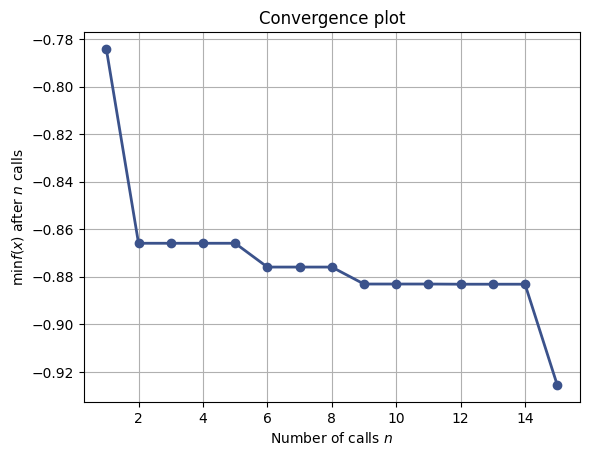

In [11]:
plot_convergence(res_gp)

### Final re-run of the Extra Trees Model with the tuned hyperparameters
There is a very minor improvement on the accuracy score, with some pretty significant increases in training time.

In [12]:
xt_reg = ExtraTreesRegressor(n_estimators=res_gp.x[0], 
                             max_depth=res_gp.x[1], 
                             min_samples_split=res_gp.x[2], 
                             min_samples_leaf=res_gp.x[3], 
                             random_state=696,n_jobs=-1
                            )
models = {'Extra Trees Regressor':xt_reg}
for key, value in models.items():
    cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
    print("Mean accuracy score: ", end="")
    print(round(cv_results['test_score'].mean(),3), end="")
    print(", best accuracy score: ", end="")
    print(round(cv_results['test_score'].max(),3), end="")
    print(", with std dev of: ", end="")
    print(round(cv_results['test_score'].std(),3))
    print("Mean training time: ", end="")
    print(round(cv_results['score_time'].mean(),3))
    print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print("**************")

Extra Trees Regressor
Mean accuracy score: 0.926, best accuracy score: 0.932, with std dev of: 0.005
Mean training time: 0.077
Score on hold out set: 0.927
**************


## Same general structure/models, now including a longer historical Ann Arbor dataset with some engineered features 
### Get historical dataset from pickle file

In [13]:
ROOT_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))
aa_pkl_loc = os.path.join(ROOT_DIR, 'data','data','aa_historical.pkl')
df = pd.read_pickle(aa_pkl_loc)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146330 entries, 2006-01-01 00:00:00 to 2022-10-07 00:00:00
Data columns (total 43 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   temp          145799 non-null  float64       
 1   dwpt          145582 non-null  float64       
 2   rhum          145582 non-null  float64       
 3   prcp          133375 non-null  float64       
 4   snow          0 non-null       float64       
 5   wdir          122688 non-null  float64       
 6   wspd          145397 non-null  float64       
 7   wpgt          0 non-null       float64       
 8   pres          141933 non-null  float64       
 9   tsun          0 non-null       float64       
 10  coco          6519 non-null    float64       
 11  Year          146330 non-null  datetime64[ns]
 12  DayOfYear     146330 non-null  float64       
 13  Hour          146330 non-null  int64         
 14  HourOfYear    146330 non-null  flo

### Basic cleaning procedures

In [14]:
df.drop(columns=['snow', 'wpgt','tsun','coco','Year'],inplace=True)
cols = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']
for col in cols:
    try:
        df[col].fillna(df[f'ATAhr-{col}'],inplace=True)
    except:
        df[col].fillna(df[f'ATAhr-{col}_x'],inplace=True)
    df[f'24hr~{col}'] = df[col].shift(-24)
df = df[df['24hr~temp'].notna()]

df.head(5)

,temp,dwpt,rhum,prcp,wdir,wspd,pres,DayOfYear,Hour,HourOfYear,...,L5Aday-wdir,L5Aday-wspd,L5Aday-pres,24hr~temp,24hr~dwpt,24hr~rhum,24hr~prcp,24hr~wdir,24hr~wspd,24hr~pres
Timestamp,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,1.0,-1.1,86.0,0.000000,240.0,14.8,1005.0,0.0,1,1.0,...,171.171171,12.634188,1017.74386,1.1,-1.1,85.0,0.000000,80.000000,11.2,1015.4
2006-01-01 01:00:00,1.1,-0.1,92.0,0.000000,240.0,14.8,1009.0,0.0,2,2.0,...,171.171171,12.634188,1017.74386,1.1,-1.1,85.0,0.000000,110.000000,9.4,1015.7
2006-01-01 02:00:00,0.6,0.0,96.0,0.235714,250.0,13.0,1009.5,0.0,3,3.0,...,171.171171,12.634188,1017.74386,1.1,-1.1,85.0,0.300000,228.666667,11.2,1015.4
2006-01-01 03:00:00,1.1,-0.1,92.0,0.000000,250.0,13.0,1009.6,0.0,4,4.0,...,171.171171,12.634188,1017.74386,1.1,-0.1,92.0,0.800000,80.000000,14.8,1015.1
2006-01-01 04:00:00,1.1,-0.7,88.0,0.000000,250.0,14.8,1010.5,0.0,5,5.0,...,171.171171,12.634188,1017.74386,1.7,-0.1,88.0,0.084615,70.000000,16.6,1014.9


### Again our target will be the '-24hr~temp_KARB0' column, and our features to use in our first prediction model will be all of the measurements at station "KARB0" 24 hours prior to our target...as well as, the engineered features listed below
 - All time average for the hour "ATAhr-x" = average for that hour of the year from 2006 to 2022
 - All time average for the day "ATAday-x" = average for that day of the year from 2006 to 2022
 - Last 5 year average for the hour "L5Ahr-x" = average for that hour from the last 5 years 2018 to 2022
 - Last 5 year average for the day "L5Aday-x" = average for that day of the year from the last 5 years 2018 to 2022
 
This cell will run 5 fold cross-validate on our 3 chosen regression models (Extra Trees Regressor, Lasso Regressor, and Tweedie Regressor). This will show how the average accuracy scores compare across these models on this expanded data set.

In [15]:
X_cols = [col for col in df.columns if "~" not in col]
X = df[X_cols]
y = df['24hr~temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=696)
xt_reg = ExtraTreesRegressor(random_state=696,n_jobs=-1)
lasso_reg = linear_model.Lasso(alpha=0.1,max_iter=1500)
tw_reg = linear_model.TweedieRegressor(max_iter=500)
dummy_reg = DummyRegressor(strategy="median")
models = {'Extra Trees Regressor':xt_reg,
          'Lasso Regressor':lasso_reg,
          'Tweedie Regressor':tw_reg,
          'Dummy Regressor':dummy_reg}
for key, value in models.items():
    cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
    print("Mean accuracy score: ", end="")
    print(round(cv_results['test_score'].mean(),3), end="")
    print(", best accuracy score: ", end="")
    print(round(cv_results['test_score'].max(),3), end="")
    print(", with std dev of: ", end="")
    print(round(cv_results['test_score'].std(),3))
    print("Mean training time: ", end="")
    print(round(cv_results['score_time'].mean(),3))
    print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print("**************")

Extra Trees Regressor
Mean accuracy score: 0.939, best accuracy score: 0.94, with std dev of: 0.001
Mean training time: 0.656
Score on hold out set: 0.946
**************
Lasso Regressor
Mean accuracy score: 0.87, best accuracy score: 0.872, with std dev of: 0.001
Mean training time: 0.003
Score on hold out set: 0.873
**************
Tweedie Regressor
Mean accuracy score: 0.868, best accuracy score: 0.871, with std dev of: 0.001
Mean training time: 0.006


c:\users\jesse\onedrive\documents\homework\mich\521\ms2_git\lib\site-packages\sklearn\linear_model\_glm\glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Score on hold out set: 0.871
**************
Dummy Regressor
Mean accuracy score: -0.001, best accuracy score: -0.0, with std dev of: 0.001
Mean training time: 0.002
Score on hold out set: -0.0
**************


### Examine the feature importances in the best performing model (Extra Trees Regressor)

In [16]:
feature_importance_df = pd.DataFrame([X.columns, xt_reg.feature_importances_]).transpose()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values('Importance',ascending=False,inplace=True)
feature_importance_df

,Feature,Importance
10,ATAhr-temp,0.250468
0,temp,0.194401
17,L5Ahr-temp,0.12466
24,ATAday-temp,0.088224
31,L5Aday-temp,0.04911
32,L5Aday-dwpt,0.035966
25,ATAday-dwpt,0.035249
11,ATAhr-dwpt,0.034425
1,dwpt,0.034257
18,L5Ahr-dwpt,0.024618


In [17]:
alt.Chart(feature_importance_df[:5]).mark_bar().encode(
    x=alt.X('Importance:Q', axis=alt.Axis(format="%", tickSize=0, labelFontSize=12)),
    y=alt.Y(
        'Feature:N', sort=list(feature_importance_df[:5].Feature), title="",
        axis=alt.Axis(tickSize=0, labelFontSize=12, labelPadding=10)),
).properties(
    height=200
)

alt.Chart(...)

### Hyper-parameter tuning the Extra Trees Regressor with the expanded dataset
5 fold cross validate looking for the optimized estimators, depth, sample split, and sample leaf parameters. Evaluating the 'best' based on the mean squared error achieved.

In [18]:
space  = [Integer(100,200, name='n_estimators'),
          Integer(1, 50, name='max_depth'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    xt_reg.set_params(**params)

    return -np.mean(cross_val_score(xt_reg, X_train, y_train, cv=5, n_jobs=-1))

res_gp = gp_minimize(objective, space, n_calls=15, random_state=696)

print(f"Best score: {res_gp.fun}")
print("Best parameters:")
print(f" - n-estimators= {res_gp.x[0]}")
print(f" - max_depth= {res_gp.x[1]}")
print(f" - min_samples_split= {res_gp.x[2]}")
print(f" - min_samples_leaf=  {res_gp.x[3]}")

Best score: -0.9398753621255287
Best parameters:
 - n-estimators= 200
 - max_depth= 36
 - min_samples_split= 2
 - min_samples_leaf=  1


### Plot the convergence of the hyperparameter tuning

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

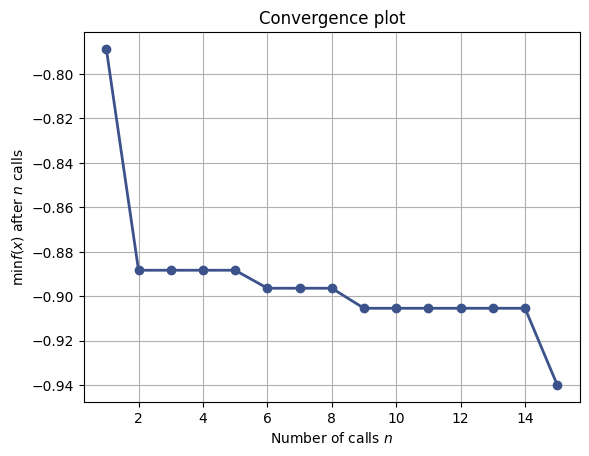

In [19]:
plot_convergence(res_gp)

### Re-train the model with the tuned hyper-parameters
Again, only marginal accuracy improvemens achieved with the tuned parameters

In [20]:
xt_reg = ExtraTreesRegressor(n_estimators=res_gp.x[0], 
                             max_depth=res_gp.x[1], 
                             min_samples_split=res_gp.x[2], 
                             min_samples_leaf=res_gp.x[3], 
                             random_state=696,n_jobs=-1
                            )
models = {'Extra Trees Regressor':xt_reg}
for key, value in models.items():
    cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
    print("Mean accuracy score: ", end="")
    print(round(cv_results['test_score'].mean(),3), end="")
    print(", best accuracy score: ", end="")
    print(round(cv_results['test_score'].max(),3), end="")
    print(", with std dev of: ", end="")
    print(round(cv_results['test_score'].std(),3))
    print("Mean training time: ", end="")
    print(round(cv_results['score_time'].mean(),3))
    print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print("**************")

Extra Trees Regressor
Mean accuracy score: 0.94, best accuracy score: 0.941, with std dev of: 0.001
Mean training time: 1.035
Score on hold out set: 0.946
**************


# UNFINISHED WORK

In [21]:
pred_df = pd.DataFrame()
pred_df['Actual'] = y.values
pred_df['XT-pred'] = xt_reg.predict(X)
# pred_df['Lo-pred'] = lasso_reg.predict(X)
# pred_df['Tw-pred'] = tw_reg.predict(X)
# pred_df['Dum-pred'] = dummy_reg.predict(X)
pred_df['TimeStamp'] = df.index
pred_df = pred_df.melt(id_vars='TimeStamp')
pred_df = pred_df[pred_df['TimeStamp'].dt.year == 2022]
pred_df = pred_df[pred_df['TimeStamp'].dt.month == 8]

In [22]:
alt.data_transformers.disable_max_rows()
alt.Chart(pred_df).mark_line().encode(
    x=alt.X('TimeStamp:T', axis=alt.Axis(tickSize=0, labelFontSize=12)),
    y=alt.Y('value:Q'),
    color='variable',
    strokeDash='variable',
    row=alt.Row('variable:N')
).properties(
    height=100,
    width=600
)

alt.Chart(...)